# Image classificartion with EfficientNetV2s
<br>Last updated on 23/01/2024 by TA.Pete</br>
<br>Objective: We aim to classify images into 10 classes of custom animal dataset using EfficientNetV2s</br>
credit:<br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html<br>
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html<br>
https://www.kaggle.com/datasets/alessiocorrado99/animals10<br>

In [ ]:
! nvidia-smi

Fri Jan 24 08:01:19 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Download dataset

In [ ]:
!wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip

--2025-01-24 08:01:14--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip [following]
--2025-01-24 08:01:14--  https://media.githubusercontent.com/media/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/Dataset_animal2.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29663352 (28M) [application/zip]
Saving to: ‘Dataset_animal2.zip’

Dataset_animal2.

In [ ]:
!unzip -q -o 'Dataset_animal2.zip'

# Library

In [ ]:
!pip install pytorch-lightning
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.5 MB/s eta 0:00:00


In [ ]:
from sklearn.exceptions import UndefinedMetricWarning

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.classification import Accuracy

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device-> cuda:{device's number}

print(device)

cuda:0


# Dataset

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = transforms.Compose(
    [transforms.Resize((230,230)),
        transforms.RandomRotation(30,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276]) #nomalize imagenet pretrain
    ])

transform = transforms.Compose(
    [transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ])

batch_size = 32

In [ ]:
class AnimalDataset(Dataset):

    def __init__(self,
                 img_dir,
                 transforms=None):

        super().__init__()
        self.label_image = ['butterfly','cat','chicken','cow','dog','elephant','horse','sheep','spider','squirrel']
        self.input_dataset = list()
        label_num = 0
        for label in self.label_image:
            _, _, files = next(os.walk(os.path.join(img_dir,label)))
            for image_name in files:
                input = [os.path.join(img_dir,label,image_name),label_num] # [image_path, label_num]
                self.input_dataset.append(input)
            label_num += 1

        self.transforms = transforms

    def __len__(self):
        return len(self.input_dataset)

    def __getitem__(self, idx):
        img = Image.open(self.input_dataset[idx][0]).convert('RGB')
        x = self.transforms(img)
        y = self.input_dataset[idx][1]
        return x,y

trainset = AnimalDataset('./Dataset_animal2/train',transform_train)
valset = AnimalDataset('./Dataset_animal2/val',transform)
testset = AnimalDataset('./Dataset_animal2/test',transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

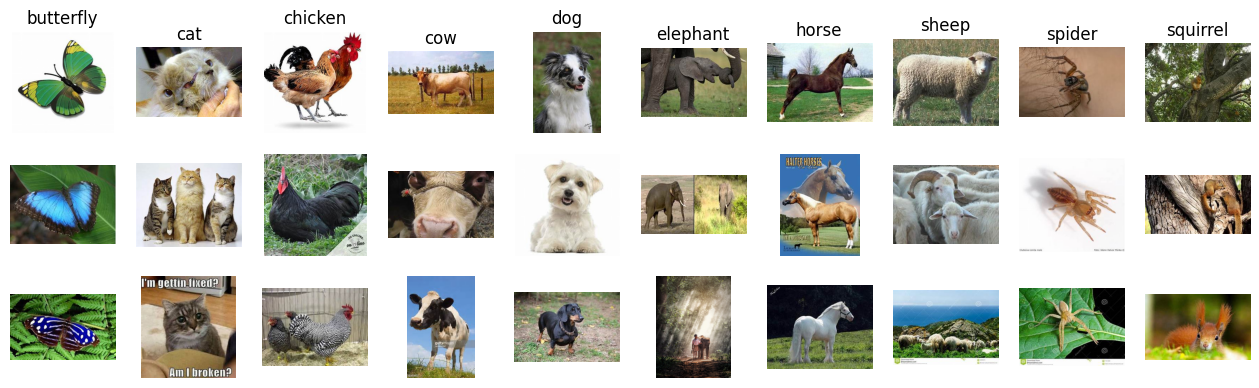

In [ ]:
def PlotRandomFromEachClass(dataset,N,labels):
    Y = [label for image_path,label in dataset.input_dataset]
    C = np.unique(Y)
    M = len(C)
    plt.figure(figsize=(16, N*1.5))
    for i in range(M):
        mask = np.squeeze(Y == C[i])
        indexes = np.random.choice(len(dataset), N, replace=False, p=mask/sum(mask))
        for j in range(N):
            plt.subplot(N,M,j*M+i+1)
            img = Image.open(dataset.input_dataset[indexes[j]][0]).convert('RGB')
            plt.imshow(img, aspect="equal")
            plt.axis("off")
            if j == 0:
                plt.title(labels[i])

# img = Image.open(self.input_dataset[idx][0]).convert('RGB')

# classes = ('butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel')
PlotRandomFromEachClass(trainset, 3, labels=trainset.label_image)

In [ ]:
trainset.__len__(), valset.__len__(), testset.__len__()

(1400, 300, 300)

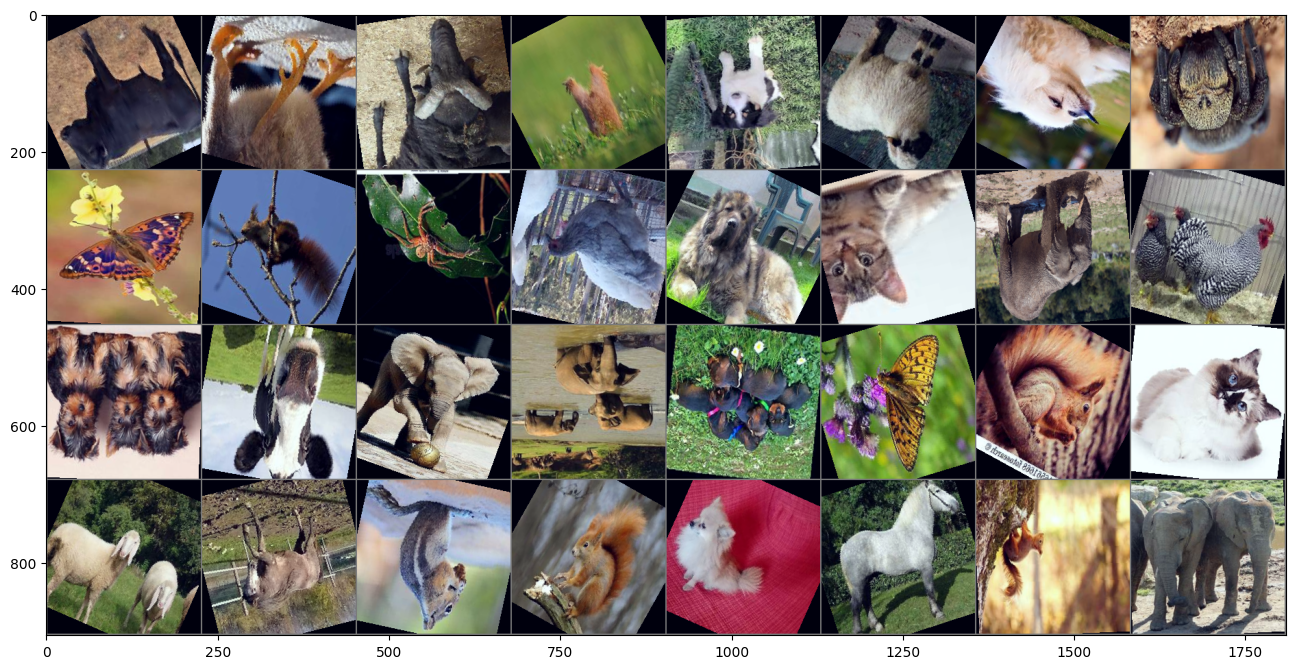

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.numpy()
    #Clipping input data to the valid range for imshow
    npimg = np.clip(npimg, 0, 1)
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 8
imshow(torchvision.utils.make_grid(images, nrow = nrow))

In [ ]:
# print labels
for i in range(batch_size//nrow+1 if batch_size % nrow else batch_size//nrow):
  print(' '.join(f'{labels[i*nrow+j]:<3}' for j in range(min(batch_size - i*nrow, nrow))))

3   2   7   9   4   7   4   8  
0   9   8   2   4   1   5   2  
4   3   5   5   4   0   9   1  
7   6   9   9   4   6   9   5  


# Model

In [ ]:
class LitEfficientNetV2(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        # Load EfficientNetV2 model from torchvision
        self.model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
        # Replace the classifier with a custom layer for our task
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.learning_rate = learning_rate
        self.train_metrics = []
        self.val_metrics = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # Collect epoch metrics

        train_loss = self.trainer.callback_metrics["train_loss"]
        train_acc = self.trainer.callback_metrics["train_acc"]
        self.train_metrics.append(
            {
                "epoch": self.current_epoch,
                "train_loss": train_loss.item(),
                "train_acc": train_acc.item(),
            }
        )

    def on_validation_epoch_end(self):
        # Update validation metrics
        val_loss = self.trainer.callback_metrics["val_loss"]
        val_acc = self.trainer.callback_metrics["val_acc"]
        self.val_metrics.append(
            {
                "val_loss": val_loss.item(),
                "val_acc": val_acc.item(),
            }
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

net = LitEfficientNetV2().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 173MB/s]


In [ ]:
from torchinfo import summary as summary_info
print(summary_info(net, input_size = (32, 3, 32, 32))) # (batchsize,channel,width,height)

Layer (type:depth-idx)                                       Output Shape              Param #
LitEfficientNetV2                                            [32, 10]                  --
├─EfficientNet: 1-1                                          [32, 10]                  --
│    └─Sequential: 2-1                                       [32, 1280, 1, 1]          --
│    │    └─Conv2dNormActivation: 3-1                        [32, 24, 16, 16]          696
│    │    └─Sequential: 3-2                                  [32, 24, 16, 16]          10,464
│    │    └─Sequential: 3-3                                  [32, 48, 8, 8]            303,552
│    │    └─Sequential: 3-4                                  [32, 64, 4, 4]            589,184
│    │    └─Sequential: 3-5                                  [32, 128, 2, 2]           917,680
│    │    └─Sequential: 3-6                                  [32, 160, 2, 2]           3,463,840
│    │    └─Sequential: 3-7                                  [32, 25

# Training

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",       # Monitor validation accuracy
    mode="max",              # Save the model with the highest accuracy
    save_top_k=1,            # Save only the best model
    filename="efficientnetv2-best-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True             # Print messages when saving
)

In [ ]:
trainer = pl.Trainer(max_epochs=1, callbacks=[checkpoint_callback])
trainer.fit(net, trainloader, valloader)

# Evaluation & Inference

In [ ]:
fig, axs = plt.subplots(2, figsize= (6,10))
# loss
axs[0].plot([entry['train_loss'] for entry in net.train_metrics], label = 'training')
axs[0].plot([entry['val_loss'] for entry in net.val_metrics], label = 'validation')
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot([entry['train_acc'] for entry in net.train_metrics], label = 'training')
axs[1].plot([entry['val_acc'] for entry in net.val_metrics], label = 'validation')
axs[1].set_title("acc")
axs[1].legend()

In [ ]:
from typing import NewType
print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = LitEfficientNetV2.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

criterion = nn.CrossEntropyLoss()
print('testing ...')
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())
        n+=1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}" )

    report = classification_report(y_labels, y_predict, digits = 4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

In [ ]:
disp.plot()
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
dataiter = iter(testloader)
inputs, labels = next(dataiter)
with torch.no_grad():

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels = list(labels.cpu().numpy())
        y_predict = list(outputs.argmax(dim=1).cpu().numpy())
        # To get probabilities, you can run a softmax on outputs
        y_probs = torch.nn.functional.softmax(outputs, dim=1)
        y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1,5,i+1)
    img = inputs[i]
    img = img*torch.tensor([0.267, 0.256, 0.276]).mean() + torch.tensor([0.507, 0.487, 0.441]).mean()     # unnormalize
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = testset.label_image[most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")